
### Complete workflow example using WatershedGeo:
1. Load MODFLOW water content data
2. Convert to resistivity model using petrophysical relationships
3. Perform forward ERT simulation
4. Conduct inversion to recover the resistivity model


In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.physics import ert
from pygimli.physics import TravelTimeManager
import pygimli.physics.traveltime as tt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Setup package path for development
try:
    # For regular Python scripts
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # For Jupyter notebooks
    current_dir = os.getcwd()

# Add the parent directory to Python path
parent_dir = os.path.dirname(current_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Import PyHydroGeophysX modules
from PyHydroGeophysX.core.interpolation import ProfileInterpolator, create_surface_lines
from PyHydroGeophysX.core.mesh_utils import MeshCreator
from PyHydroGeophysX.petrophysics.resistivity_models import water_content_to_resistivity
from PyHydroGeophysX.petrophysics.velocity_models import HertzMindlinModel, DEMModel
from PyHydroGeophysX.forward.ert_forward import ERTForwardModeling
from PyHydroGeophysX.inversion.ert_inversion import ERTInversion
from PyHydroGeophysX.Hydro_modular import hydro_to_ert


In [2]:
output_dir = "results/workflow_example"
os.makedirs(output_dir, exist_ok=True)

# Step by Step approach

## Loading domain information...

In [3]:
# These would be your actual data files
data_dir = "data/"
modflow_dir = os.path.join(data_dir, "modflow")

# Load domain information from files
# (Replace with your actual file paths)
idomain = np.loadtxt(os.path.join(data_dir, "id.txt"))
top = np.loadtxt(os.path.join(data_dir, "top.txt"))
porosity = np.load(os.path.join(data_dir, "Porosity.npy"))

## Loading MODFLOW water content data..

In [4]:
# Step 2: Exmaple of loading MODFLOW water content data


# Note that to save the loading time, we only use a low resoluation model load for the example
# In a real-world application, you would load the full resolution data
# here we will load the npy file for the water content to save time

# Load the water content from a .npy file for demonstration purposes

Water_Content = np.load(os.path.join(data_dir, "Watercontent.npy"))

water_content = Water_Content[50]
print(water_content.shape)

(14, 194, 157)


## Set up profile for 2D section

In [5]:
# Step 3: Set up profile for 2D section
print("Step 3: Setting up profile...")

# Define profile endpoints
point1 = [115, 70]  # [col, row]
point2 = [95, 180]  # [col, row]

# Initialize profile interpolator
interpolator = ProfileInterpolator(
    point1=point1,
    point2=point2,
    surface_data=top,
    origin_x=569156.0,
    origin_y=4842444.0,
    pixel_width=1.0,
    pixel_height=-1.0,
    num_points = 400
)

Step 3: Setting up profile...


## Interpolating data to profile

In [6]:
# Step 4: Interpolate data to profile

# Interpolate water content to profile
water_content_profile = interpolator.interpolate_3d_data(water_content)

# Interpolate porosity to profile
porosity_profile = interpolator.interpolate_3d_data(porosity)

## Creating mesh

In [7]:

# Load structure layers
bot = np.load(os.path.join(data_dir, "bot.npy"))

# Process layers to get structure
structure = interpolator.interpolate_layer_data([top] + bot.tolist())

# Create surface lines
# Indicate the layer for the structure regolith, fractured bedrock and fresh bedrock
top_idx=int(0)
mid_idx=int(4)
bot_idx=int(12)
surface, line1, line2 = create_surface_lines(
    L_profile=interpolator.L_profile,
    structure=structure,
    top_idx=0,
    mid_idx=4,
    bot_idx=12
)

# Create mesh
mesh_creator = MeshCreator(quality=32)
mesh, geom = mesh_creator.create_from_layers(
    surface=surface,
    layers=[line1, line2],
    bottom_depth= np.min(line2[:,1])-10 #50.0
)

# Save mesh
mesh.save(os.path.join(output_dir, "mesh.bms"))

1

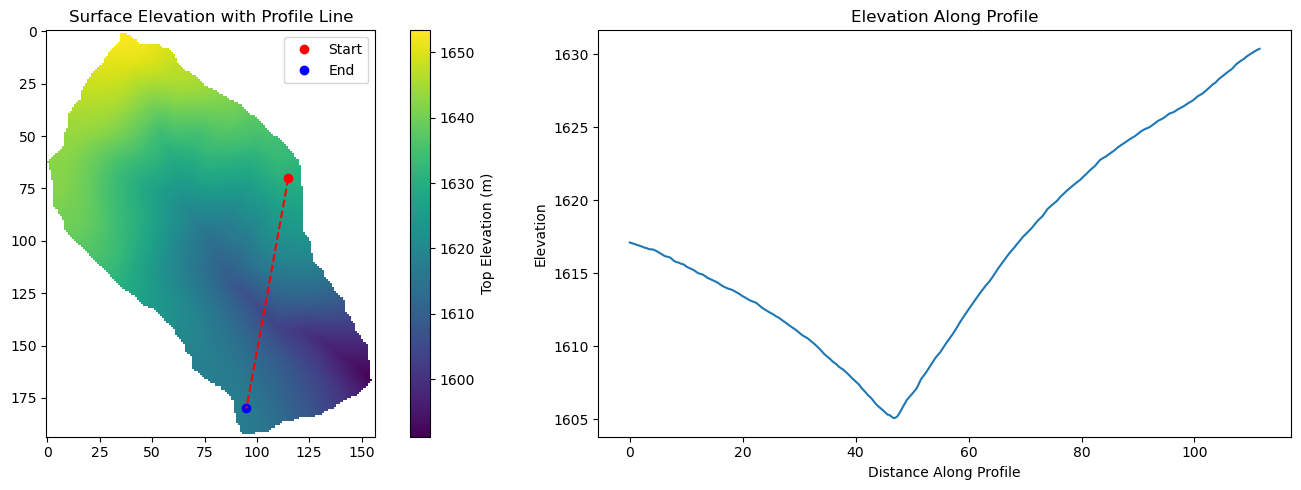

In [8]:
# Visualize the result
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
top[idomain==0] = np.nan  # Mask out the inactive cells in the top layer
# Plot the surface and profile line
plt.subplot(121)
plt.imshow(top)
plt.colorbar(label='Top Elevation (m)')
plt.plot(point1[0], point1[1], 'ro', label='Start')
plt.plot(point2[0], point2[1], 'bo', label='End')
plt.plot([point1[0], point2[0]], [point1[1], point2[1]], 'r--')
plt.legend()
plt.title('Surface Elevation with Profile Line')

# Plot the profile coordinates
plt.subplot(122)
plt.plot(surface[:,0], surface[:,1])
plt.title('Elevation Along Profile')
plt.xlabel('Distance Along Profile')
plt.ylabel('Elevation')

plt.tight_layout()
plt.show()

## Interpolating data to mesh

In [9]:
# Step 6: Interpolate data to mesh


ID1 = porosity_profile.copy()
ID1[:mid_idx] = 0 #regolith
ID1[mid_idx:bot_idx] = 3 # fractured bedrock
ID1[bot_idx:] = 2 # fresh bedrock

# Get mesh centers and markers
mesh_centers = np.array(mesh.cellCenters())
mesh_markers = np.array(mesh.cellMarkers())

# Interpolate porosity to mesh
porosity_mesh = interpolator.interpolate_to_mesh(
    property_values=porosity_profile,
    depth_values=structure,
    mesh_x=mesh_centers[:, 0],
    mesh_y=mesh_centers[:, 1],
    mesh_markers=mesh_markers,
    ID=ID1, # Use ID1 to indicate the layers for interpolation
    layer_markers = [0,3,2],

)

# Interpolate water content to mesh
wc_mesh = interpolator.interpolate_to_mesh(
    property_values=water_content_profile,
    depth_values=structure,
    mesh_x=mesh_centers[:, 0],
    mesh_y=mesh_centers[:, 1],
    mesh_markers=mesh_markers,
    ID=ID1, # Use ID1 to indicate the layers for interpolation
    layer_markers = [0,3,2],

)

In [10]:
ID1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [3., 3., 3., ..., 3., 3., 3.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]])

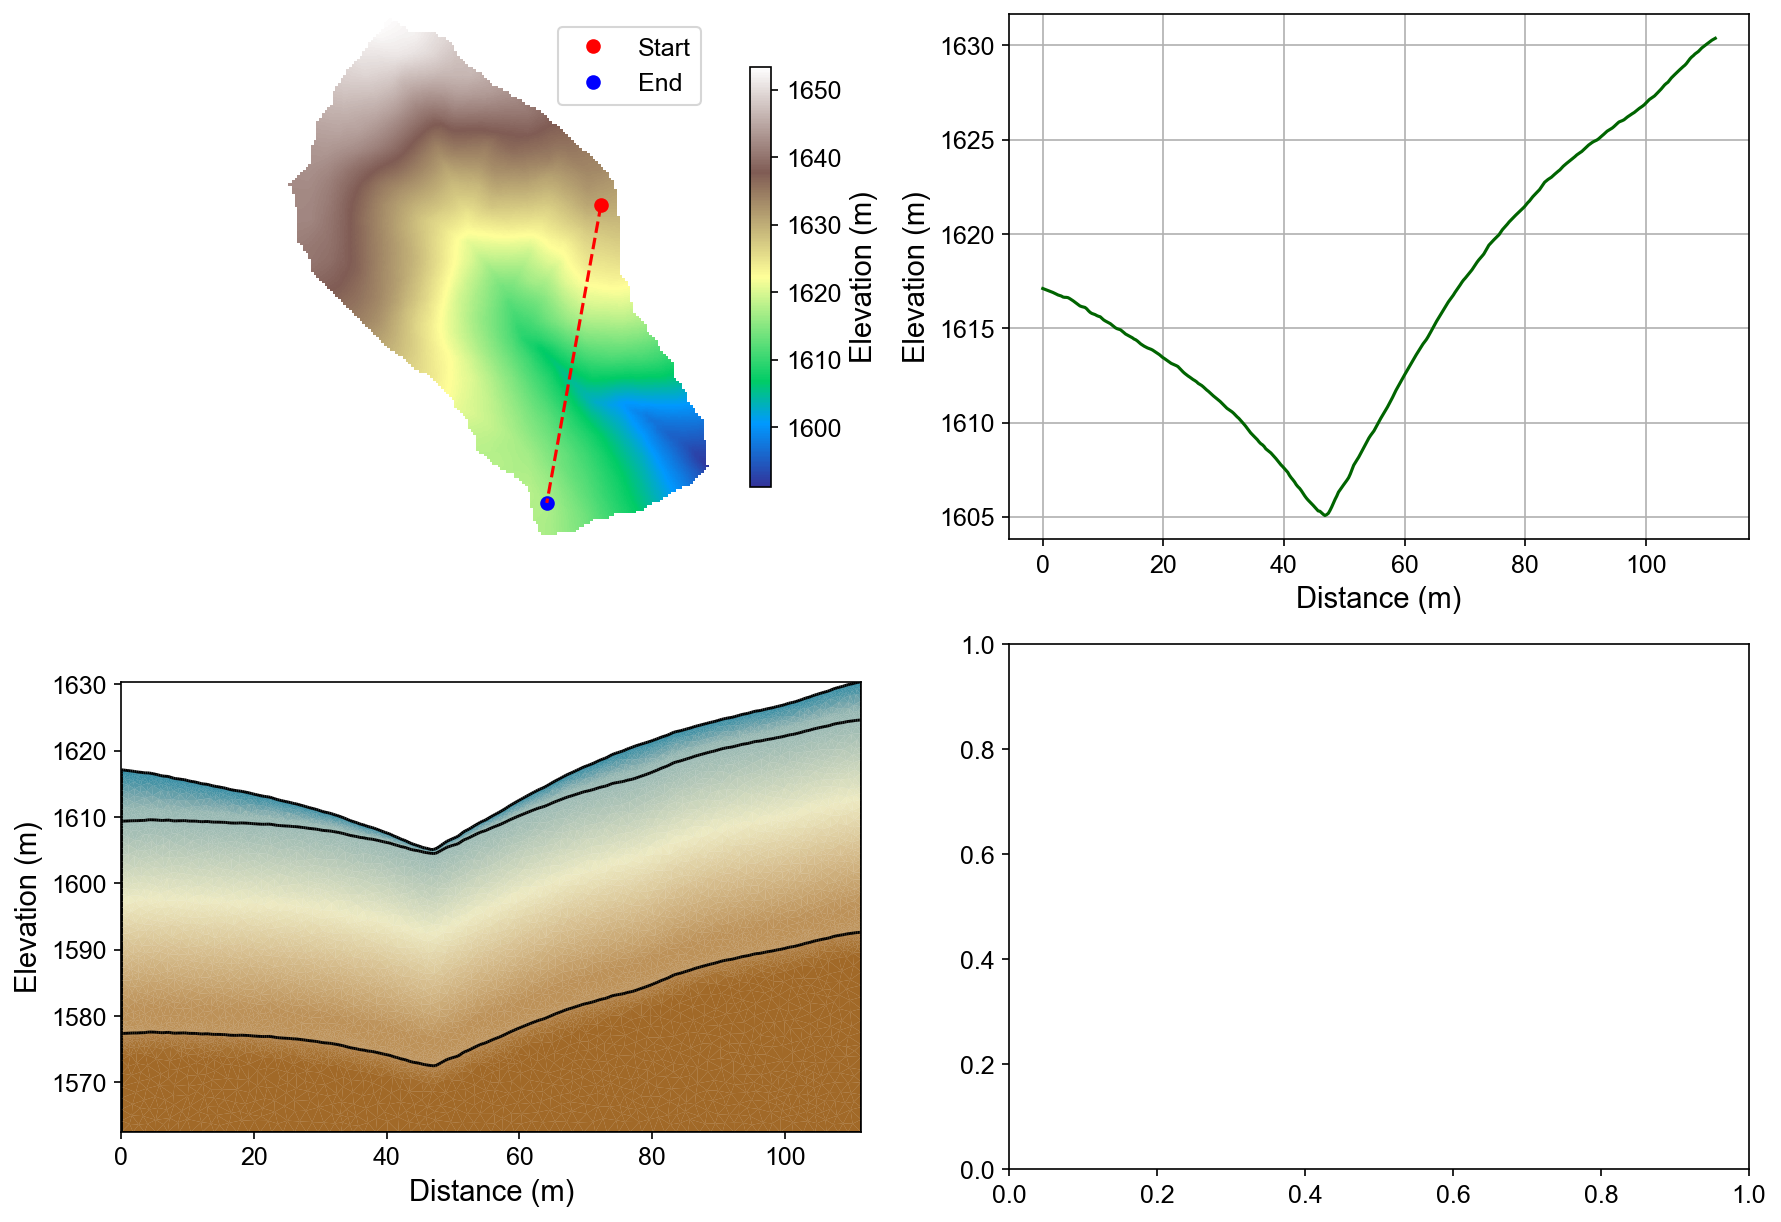

<Figure size 960x720 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pygimli as pg
from palettable.cartocolors.diverging import Earth_7

# Font settings for publication
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['figure.dpi'] = 150

# Preprocessing
top_masked = np.copy(top)
top_masked[idomain == 0] = np.nan
saturation = wc_mesh / porosity_mesh
ctcolor = Earth_7.mpl_colormap

# Create 2x2 figure
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# --- Top Left: Surface elevation map ---
im0 = axs[0, 0].imshow(top_masked, origin='lower', cmap='terrain')
axs[0, 0].invert_yaxis()

# Plot profile line and points
axs[0, 0].plot(point1[0], point1[1], 'ro', label='Start')
axs[0, 0].plot(point2[0], point2[1], 'bo', label='End')
axs[0, 0].plot([point1[0], point2[0]], [point1[1], point2[1]], 'r--')

# Remove ticks and axis borders
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
for spine in axs[0, 0].spines.values():
    spine.set_visible(False)

# Title and colorbar

cbar0 = fig.colorbar(im0, ax=axs[0, 0], orientation='vertical', shrink=0.8)
cbar0.set_label('Elevation (m)')
axs[0, 0].legend(loc='upper right')

# --- Top Right: Elevation profile ---
axs[0, 1].plot(surface[:, 0], surface[:, 1], color='darkgreen')

axs[0, 1].set_xlabel('Distance (m)')
axs[0, 1].set_ylabel('Elevation (m)')
axs[0, 1].grid(True)

# --- Bottom Left: Porosity mesh ---
pg.show(mesh, porosity_mesh,
        ax=axs[1, 0], orientation="vertical", cMap=ctcolor,
        cMin=0.05, cMax=0.45,
        xlabel="Distance (m)", ylabel="Elevation (m)",
        label='Porosity (-)', showColorBar=True)

# --- Bottom Right: Saturation mesh ---
pg.show(mesh, saturation,
        ax=axs[1, 1], orientation="vertical", cMap='Blues',
        cMin=0, cMax=1,
        xlabel="Distance (m)", ylabel="Elevation (m)",
        label='Saturation (-)', showColorBar=True)

# Layout adjustment
plt.tight_layout(pad=3)
plt.savefig(os.path.join(output_dir, "topography_and_properties.tiff"), dpi=300)


In [12]:
print("Water Content min/max:", np.min(wc_mesh), np.max(wc_mesh))
print("Saturation min/max:", np.min(saturation), np.max(saturation))


Water Content min/max: 0.04999999999999998 0.27217677063432144
Saturation min/max: 0.26787257055093544 1.0


## Calculating saturation

In [13]:


# Ensure porosity is not zero to avoid division by zero
porosity_safe = np.maximum(porosity_mesh, 0.01)
saturation = np.clip(wc_mesh / porosity_safe, 0.0, 1.0)


## Converting to resistivity

In [14]:

# Step 8: Convert to resistivity using petrophysical model


marker_labels = [0, 3, 2] # top. mid, bottom layers (example values)
rho_sat = [100, 500, 2400] # Saturated resistivity for each layer (example values)
n = [2.2, 1.8, 2.5] # Cementation exponent for each layer (example values)
sigma_s = [1/500, 0, 0] # Saturated resistivity of the surface conductivity see Chen & Niu, (2022) for each layer (example values)
# Convert water content back to resistivity

res_models = np.zeros_like(wc_mesh)  # Initialize an array for resistivity values

mask = (mesh_markers == marker_labels[0])
top_res = water_content_to_resistivity(
    wc_mesh[mask],                  # Water content values for this layer
    float(rho_sat[0]),              # Use a scalar value instead of an array
    float(n[0]),                    # Use a scalar value instead of an array
    porosity_mesh[mask],            # Porosity values for this layer
    sigma_s[0] # Use a scalar value
)
res_models[mask] = top_res

mask = (mesh_markers == marker_labels[1])
mid_res = water_content_to_resistivity(
    wc_mesh[mask],                  # Water content values for this layer
    float(rho_sat[1]),              # Use a scalar value instead of an array
    float(n[1]),                    # Use a scalar value instead of an array
    porosity_mesh[mask],            # Porosity values for this layer
    sigma_s[1]  # Use a scalar value
)
res_models[mask] = mid_res


mask = (mesh_markers == marker_labels[2])
bot_res = water_content_to_resistivity(
    wc_mesh[mask],                  # Water content values for this layer
    float(rho_sat[2]),              # Use a scalar value instead of an array
    float(n[2]),                    # Use a scalar value instead of an array
    porosity_mesh[mask],            # Porosity values for this layer
    sigma_s[2]
)
res_models[mask] = bot_res


In [15]:
print(np.min(top_res), np.max(top_res))
print(np.min(mid_res), np.max(mid_res))
print(np.min(bot_res), np.max(bot_res))

350.63114674639996 1038.385274355005
500.0 2863.5857671555473
2400.0 2400.0


## Converting to P wave velocity

In [16]:
# Step 9: Convert to P wave velocity using petrophysical model


# Initialize velocity models
hm_model = HertzMindlinModel(critical_porosity=0.4, coordination_number=6.0)
dem_model = DEMModel()

# Initialize velocity model
velocity_mesh = np.zeros_like(wc_mesh)




top_mask = (mesh_markers == marker_labels[0])
top_bulk_modulus = 30.0  # GPa
top_shear_modulus = 20.0  # GPa
top_mineral_density = 2650  # kg/m³
top_depth = 1.0  # m

# Get Vp values using Hertz-Mindlin model
Vp_high, Vp_low = hm_model.calculate_velocity(
    porosity=porosity_mesh[top_mask],
    saturation=saturation[top_mask],
    bulk_modulus=top_bulk_modulus,
    shear_modulus=top_shear_modulus,
    mineral_density=top_mineral_density,
    depth=top_depth
)

# Use average of high and low bounds
velocity_mesh[top_mask] = (Vp_high + Vp_low) / 2



mid_mask = (mesh_markers == marker_labels[1])

mid_bulk_modulus = 50.0  # GPa
mid_shear_modulus = 35.0 # GPa
mid_mineral_density = 2670  # kg/m³
mid_aspect_ratio = 0.05

# Get Vp values using DEM model
_, _, Vp = dem_model.calculate_velocity(
    porosity=porosity_mesh[mid_mask],
    saturation=saturation[mid_mask],
    bulk_modulus=mid_bulk_modulus,
    shear_modulus=mid_shear_modulus,
    mineral_density=mid_mineral_density,
    aspect_ratio=mid_aspect_ratio
)

velocity_mesh[mid_mask] = Vp

bot_mask = (mesh_markers == marker_labels[2])
bot_bulk_modulus = 55  # GPa
bot_shear_modulus = 50  # GPa
bot_mineral_density = 2680  # kg/m³
bot_aspect_ratio = 0.03

# Get Vp values using DEM model
_, _, Vp = dem_model.calculate_velocity(
    porosity=porosity_mesh[bot_mask],
    saturation=saturation[bot_mask],
    bulk_modulus=bot_bulk_modulus,
    shear_modulus=bot_shear_modulus,
    mineral_density=bot_mineral_density,
    aspect_ratio=bot_aspect_ratio
)

velocity_mesh[bot_mask] = Vp

In [17]:
print(np.min(velocity_mesh[top_mask]), np.max(velocity_mesh[top_mask]))
print(np.min(velocity_mesh[mid_mask]), np.max(velocity_mesh[mid_mask]))
print(np.min(velocity_mesh[bot_mask]), np.max(velocity_mesh[bot_mask]))

530.5407111481036 1171.922856081107
1316.9929234300878 4138.234174753382
4541.876108086146 5264.711328313164


Velocity range: 530.5407111481036 5264.711328313164


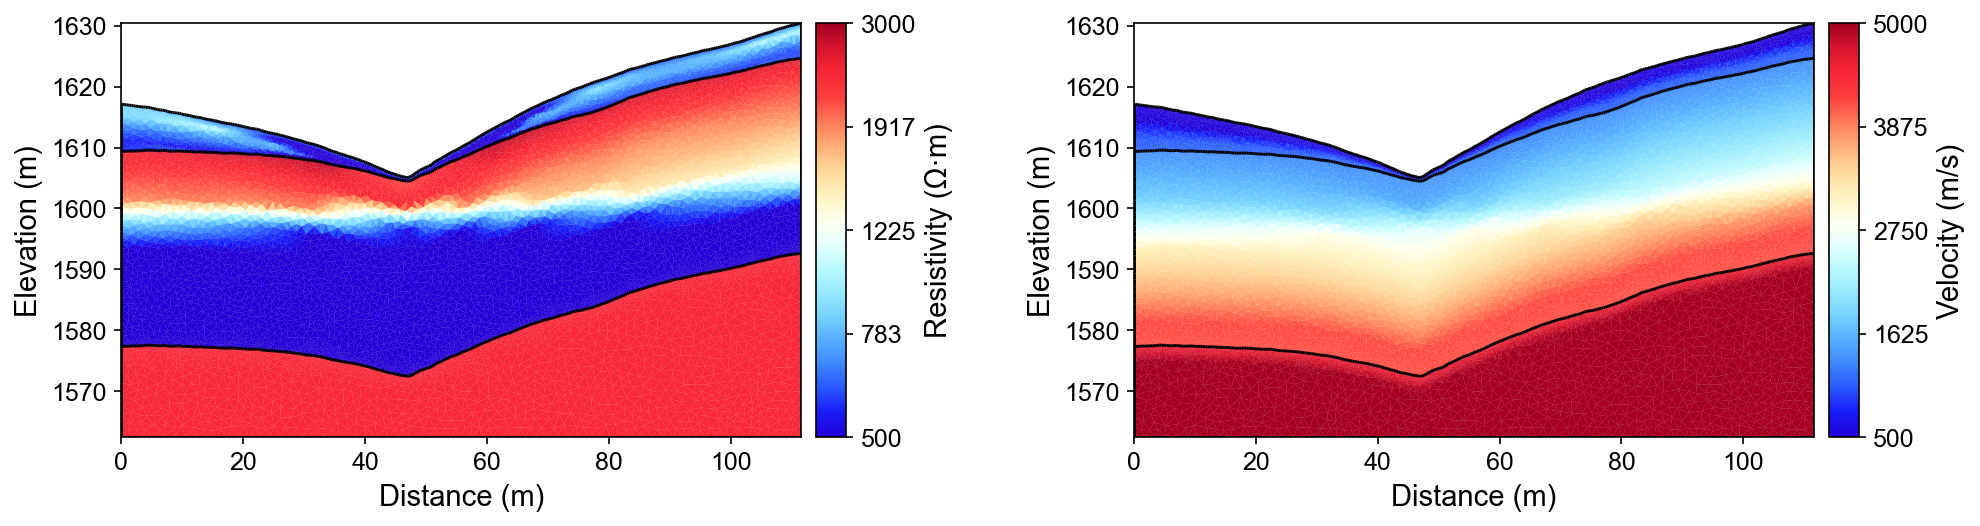

In [18]:
from palettable.lightbartlein.diverging import BlueDarkRed18_18
fixed_cmap = BlueDarkRed18_18.mpl_colormap



# --- Create figure with 1 row, 2 columns ---
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# --- Left: Resistivity with log scale ---
pg.show(mesh, res_models, ax=axs[0], orientation="vertical",
        cMap=fixed_cmap, logScale=True, showColorBar=True,
        xlabel="Distance (m)", ylabel="Elevation (m)",
        label='Resistivity (Ω·m)', cMin=500, cMax=3000)


# --- Right: P-wave velocity with fixed color scale ---
pg.show(mesh, velocity_mesh, ax=axs[1], orientation="vertical",
        cMap=fixed_cmap, cMin=500, cMax=5000, showColorBar=True,
        xlabel="Distance (m)", ylabel="Elevation (m)",
        label='Velocity (m/s)')

# --- Print value range for debugging ---
print("Velocity range:", np.min(velocity_mesh), np.max(velocity_mesh))

# --- Final layout ---
plt.tight_layout(pad=3)

plt.savefig(os.path.join(output_dir, "res_vel.tiff"), dpi=300)

## ERT forward modeling simulation

Step 9: Creating ERT survey design...
Step 10: Performing forward modeling...


22/05/25 - 14:21:27 - pyGIMLi - INFO - Found 2 regions.
22/05/25 - 14:21:27 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
22/05/25 - 14:21:28 - pyGIMLi - INFO - Found 2 regions.
22/05/25 - 14:21:28 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
22/05/25 - 14:21:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
22/05/25 - 14:21:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
22/05/25 - 14:21:29 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 37828 Cells: 74804 Boundaries: 56528


1

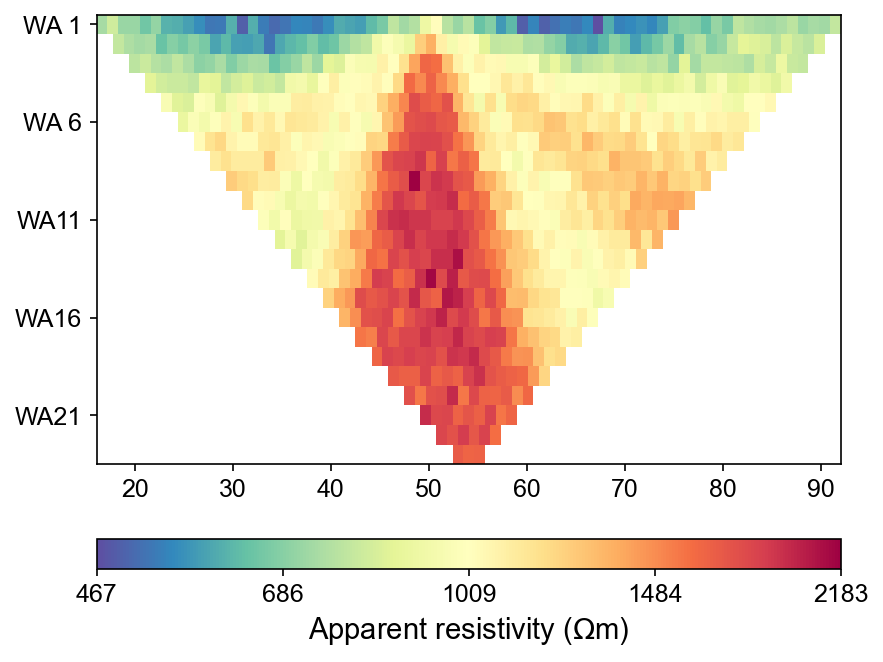

In [19]:



xpos = np.linspace(15,15+72 - 1,72)
ypos = np.interp(xpos,interpolator.L_profile,interpolator.surface_profile)
pos = np.hstack((xpos.reshape(-1,1),ypos.reshape(-1,1)))

schemeert = ert.createData(elecs=pos,schemeName='wa')

# Step 10: Forward modeling to create synthetic ERT data

mesh.setCellMarkers(np.ones(mesh.cellCount())*2)
grid = pg.meshtools.appendTriangleBoundary(mesh, marker=1,
                                          xbound=100, ybound=100)

fwd_operator = ERTForwardModeling(mesh=grid, data=schemeert)


synth_data = schemeert.copy()
fob = ert.ERTModelling()
fob.setData(schemeert)
fob.setMesh(grid)
dr = fob.response(res_models)

dr *= 1. + pg.randn(dr.size()) * 0.05
ert_manager = ert.ERTManager(synth_data)
synth_data['rhoa'] = dr
synth_data['err'] = ert_manager.estimateError(synth_data, absoluteUError=0.0, relativeError=0.05)
ert.showData(synth_data,  logscale=True)
synth_data.save(os.path.join(output_dir, "synthetic_data.dat"))

In [20]:
################## Seismic data #####################

print("Step 11: Creating seismic survey design...")

numberGeophones = 72
shotDistance = 5
sensors = np.linspace(15,15 + 72 - 1, numberGeophones)
scheme = pg.physics.traveltime.createRAData(sensors,shotDistance=shotDistance)



for i in range(numberGeophones):
    minusx = np.abs(surface[:,0]-sensors[i])
    index = np.where(minusx== np.amin(minusx))
    new_x = surface[index,0]
    new_y = surface[index,1]
    pos[i, 0] = new_x
    pos[i, 1] = new_y


scheme.setSensors(pos)


mgr = TravelTimeManager()
datasrt = mgr.simulate(slowness=1.0 / velocity_mesh, scheme=scheme, mesh=mesh,
                    noiseLevel=0.05, noiseAbs=0.00001, seed=1334
                    ,verbose=True)
datasrt.save(os.path.join(output_dir, "synthetic_seismic_data.dat"))

C:\Users\HChen8\AppData\Local\Temp\ipykernel_20356\3143686705.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos[i, 0] = new_x
C:\Users\HChen8\AppData\Local\Temp\ipykernel_20356\3143686705.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos[i, 1] = new_y
22/05/25 - 14:24:57 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.


Step 11: Creating seismic survey design...
min/max t: 0.0015063468542891626 0.05156406269601664


1

<Axes: xlabel='Distance (m)', ylabel='Traveltime (s)'>

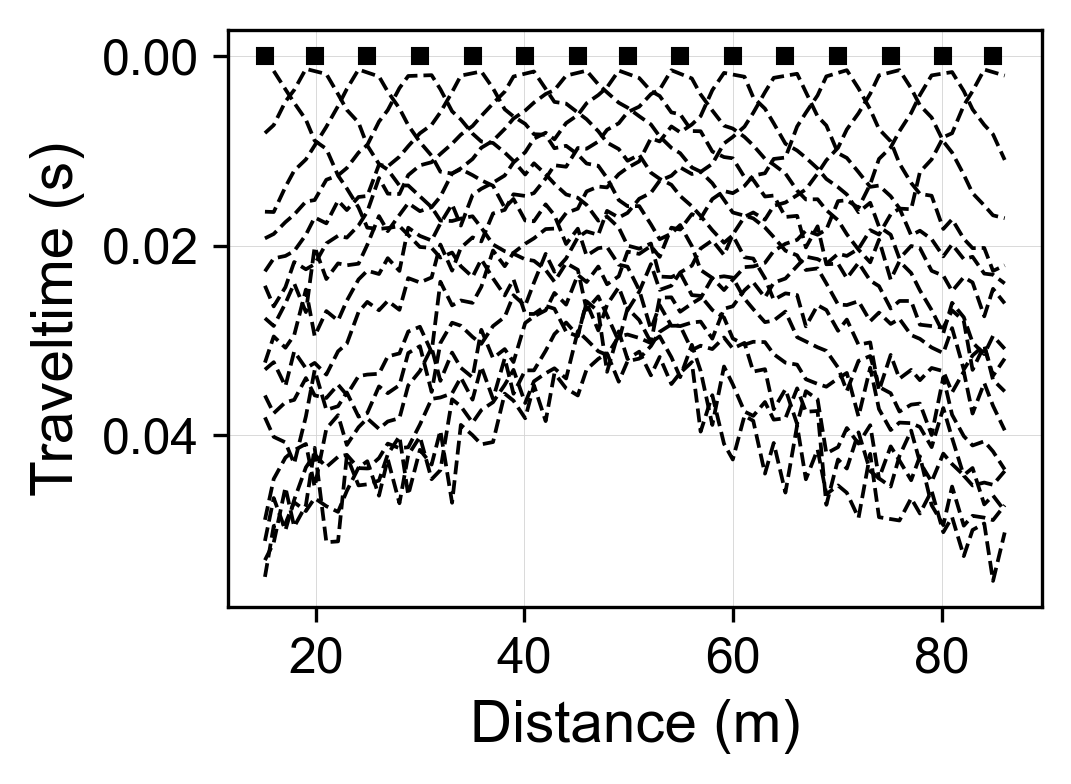

In [21]:
def drawFirstPicks(ax, data, tt=None, plotva=False, **kwargs):
    """Plot first arrivals as lines.
    
    Parameters
    ----------
    ax : matplotlib.axes
        axis to draw the lines in
    data : :gimliapi:`GIMLI::DataContainer`
        data containing shots ("s"), geophones ("g") and traveltimes ("t")
    tt : array, optional
        traveltimes to use instead of data("t")
    plotva : bool, optional
        plot apparent velocity instead of traveltimes
    
    Return
    ------
    ax : matplotlib.axes
        the modified axis
    """
    # Extract coordinates
    px = pg.x(data)
    gx = np.array([px[int(g)] for g in data("g")])
    sx = np.array([px[int(s)] for s in data("s")])
    
    # Get traveltimes
    if tt is None:
        tt = np.array(data("t"))
    if plotva:
        tt = np.absolute(gx - sx) / tt
    
    # Find unique source positions    
    uns = np.unique(sx)
    
    # Override kwargs with clean, minimalist style
    kwargs['color'] = 'black'
    kwargs['linestyle'] = '--'
    kwargs['linewidth'] = 0.9
    kwargs['marker'] = None  # No markers on the lines
    
    # Plot for each source
    for i, si in enumerate(uns):
        ti = tt[sx == si]
        gi = gx[sx == si]
        ii = gi.argsort()
        
        # Plot line
        ax.plot(gi[ii], ti[ii], **kwargs)
        
        # Add source marker as black square at top
        ax.plot(si, 0.0, 's', color='black', markersize=4, 
                markeredgecolor='black', markeredgewidth=0.5)
    
    # Clean grid style
    ax.grid(True, linestyle='-', linewidth=0.2, color='lightgray')
    
    # Set proper axis labels with units
    if plotva:
        ax.set_ylabel("Apparent velocity (m s$^{-1}$)")
    else:
        ax.set_ylabel("Traveltime (s)")
    
    ax.set_xlabel("Distance (m)")
    

    

    
    # Invert y-axis for traveltimes
    ax.invert_yaxis()

    return ax

# Usage
fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=300) 
drawFirstPicks(ax, datasrt)

Velocity range: 530.5407111481036 5264.711328313164


C:\Users\HChen8\AppData\Local\Temp\ipykernel_20356\593002678.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


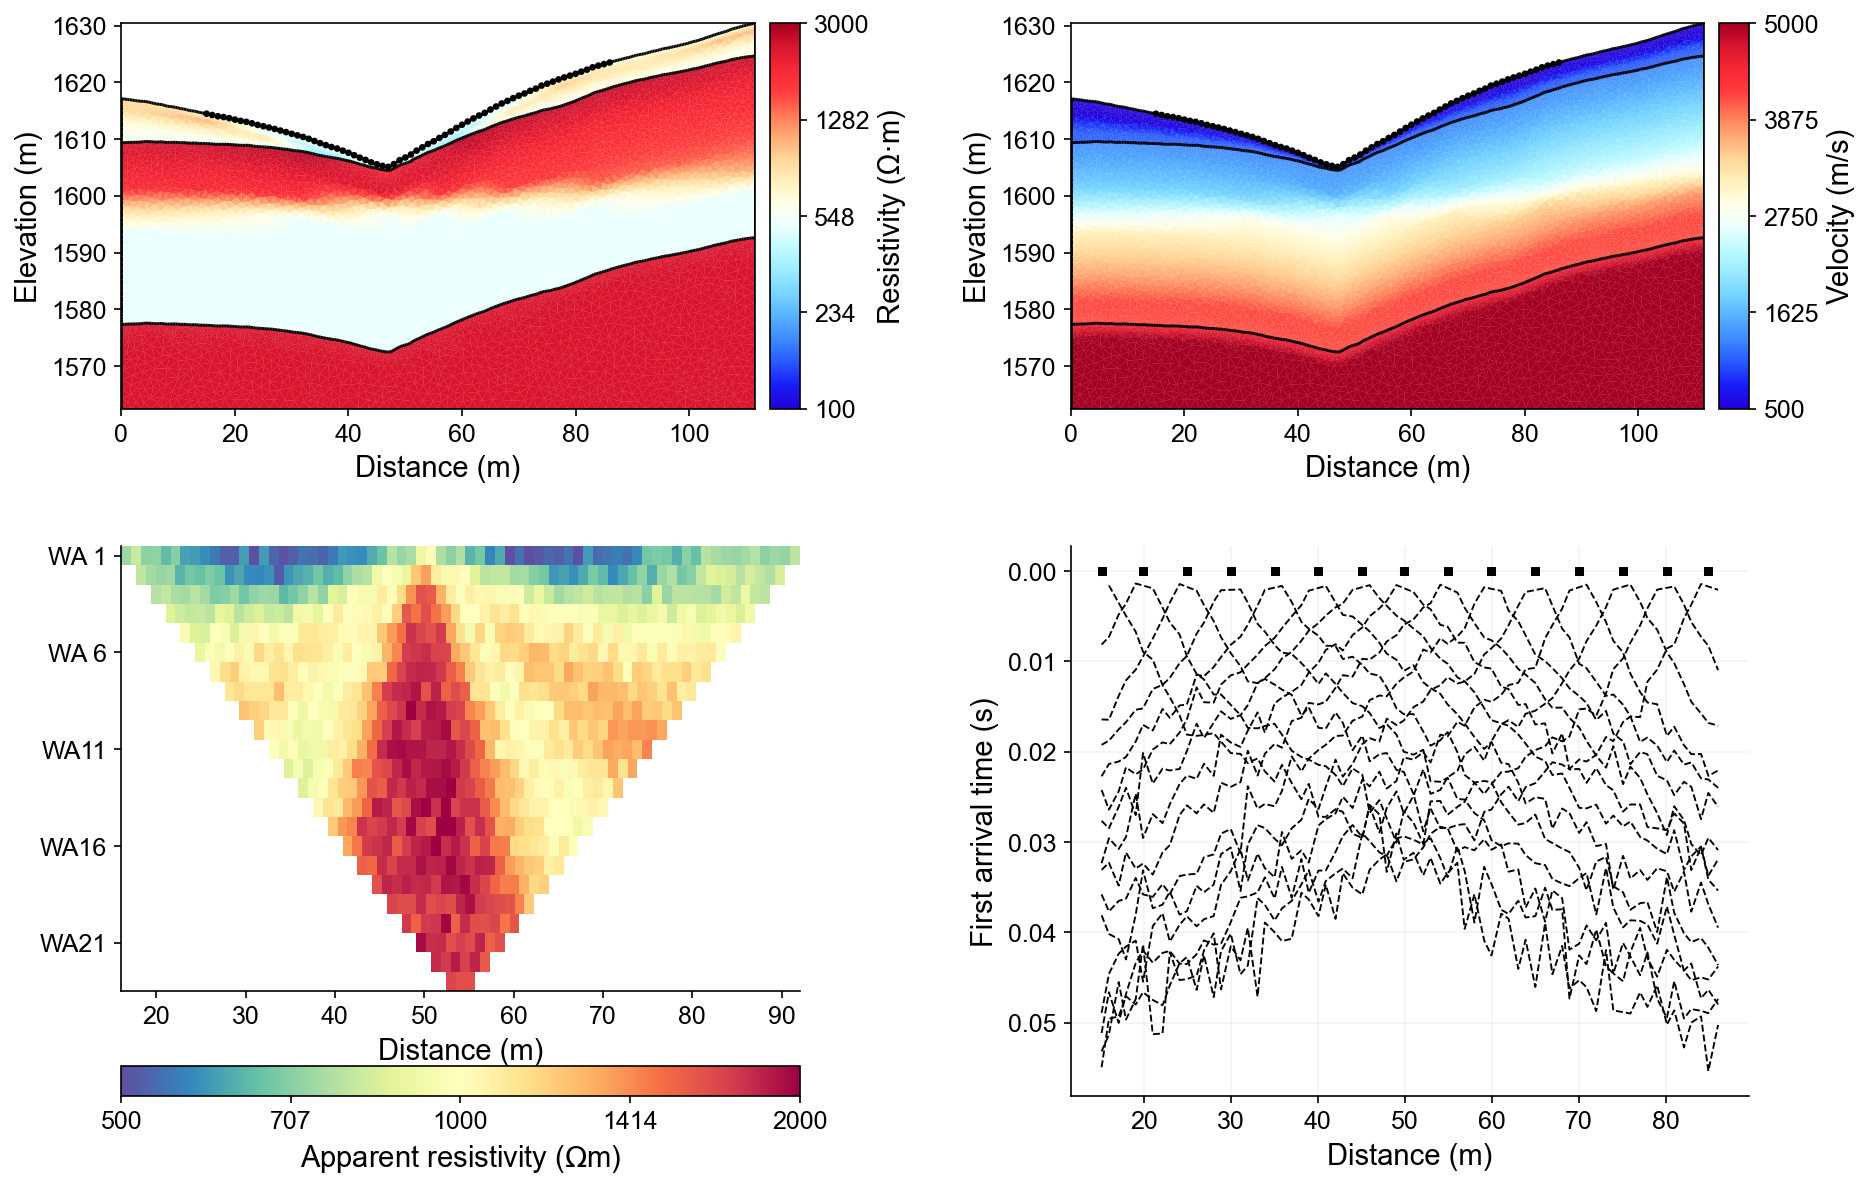

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg

# Assume mesh, res_models, velocity_mesh, fixed_cmap, synth_data, datasrt, ert, drawFirstPicks are already defined

# Create 2×2 axes
fig, axs = plt.subplots(2, 2, figsize=(14, 10),
                        gridspec_kw={'hspace': 0.1, 'wspace': 0.4})

# Flatten for easy indexing
ax1, ax2, ax3, ax4 = axs.flatten()

# --- Top left: Resistivity (log scale) ---
pg.show(mesh, res_models, ax=ax1, orientation="vertical",
        cMap=fixed_cmap, logScale=True, showColorBar=True,
        xlabel="Distance (m)", ylabel="Elevation (m)",
        label='Resistivity (Ω·m)', cMin=100, cMax=3000)
# Invert y (so elevation decreases downward)
pg.viewer.mpl.drawSensors(ax1, schemeert.sensors(), diam=0.8,
                         facecolor='black', edgecolor='black')


# --- Top right: P-wave velocity (fixed scale) ---
pg.show(mesh, velocity_mesh, ax=ax2, orientation="vertical",
        cMap=fixed_cmap, cMin=500, cMax=5000, showColorBar=True,
        xlabel="Distance (m)", ylabel="Elevation (m)",
        label='Velocity (m/s)')
pg.viewer.mpl.drawSensors(ax2, schemeert.sensors(), diam=0.8,
                         facecolor='black', edgecolor='black')


# Print range for debugging
print("Velocity range:", np.min(velocity_mesh), np.max(velocity_mesh))

# --- Bottom left: Synthetic ERT data ---
ert.showData(synth_data, logscale=True, ax=ax3, cMin=500, cMax=2000,cmap='jet')

ax3.set_xlabel("Distance (m)")
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# --- Bottom right: First-break picks ---
drawFirstPicks(ax=ax4, data=datasrt)

ax4.set_xlabel("Distance (m)")
ax4.set_ylabel("First arrival time (s)")
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "ert_seismic.tiff"), dpi=300)


In [23]:
# Step 11: Run ERT inversion on synthetic data

## using my code to the inversion
print("Step 11: Running ERT inversion...")

# Create ERT inversion object
inversion = ERTInversion(
    data_file=os.path.join(output_dir, "synthetic_data.dat"),
    lambda_val=10.0,
    method="cgls",
    use_gpu=True,
    max_iterations=10,
    lambda_rate= 1.0
)
inversion_result = inversion.run()

22/05/25 - 14:25:22 - pyGIMLi - INFO - Found 2 regions.
22/05/25 - 14:25:22 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
22/05/25 - 14:25:22 - pyGIMLi - INFO - Found 2 regions.
22/05/25 - 14:25:22 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
22/05/25 - 14:25:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
22/05/25 - 14:25:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Step 11: Running ERT inversion...


22/05/25 - 14:25:22 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 4193 Cells: 7984 Boundaries: 6188


-------------------Iteration: 0 ---------------------------
chi2: [[31.96002247]]
dPhi: 1.0
-------------------Iteration: 1 ---------------------------
chi2: [[2.69620898]]
dPhi: [[0.91563808]]
-------------------Iteration: 2 ---------------------------
chi2: [[1.0897884]]
dPhi: [[0.59580715]]
End of inversion


In [24]:
## Using Pygimili default to the inversion
mgr = ert.ERTManager(os.path.join(output_dir, "synthetic_data.dat"))
inv = mgr.invert(lam=10, verbose=True,quality=34)

22/05/25 - 14:25:45 - pyGIMLi - INFO - Found 2 regions.
22/05/25 - 14:25:45 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
22/05/25 - 14:25:45 - pyGIMLi - INFO - Found 2 regions.
22/05/25 - 14:25:45 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
22/05/25 - 14:25:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
22/05/25 - 14:25:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
22/05/25 - 14:25:45 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 4193 Cells: 7984 Boundaries: 6188
22/05/25 - 14:25:45 - pyGIMLi - INFO - Use median(data values)=1093.73179826467
22/05/25 - 14:25:45 - pyGIMLi - INFO - Created startmodel from forward operator: 1438, min/max=1093.731798/1093.731798
22/05/25 - 14:25:45 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001FC34EAB100>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001FC34EAB380>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000001FB6E542D90>
min/max (data): 467/2183
min/max (error): 5%/5%
min/max (start model): 1094/1094
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =   30.43
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    2.56 (dPhi = 90.79%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    1.06 (dPhi = 52.15%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    1.02 (dPhi = 2.74%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    0.99 (dPhi = 1.31%) lam: 10.0


#################

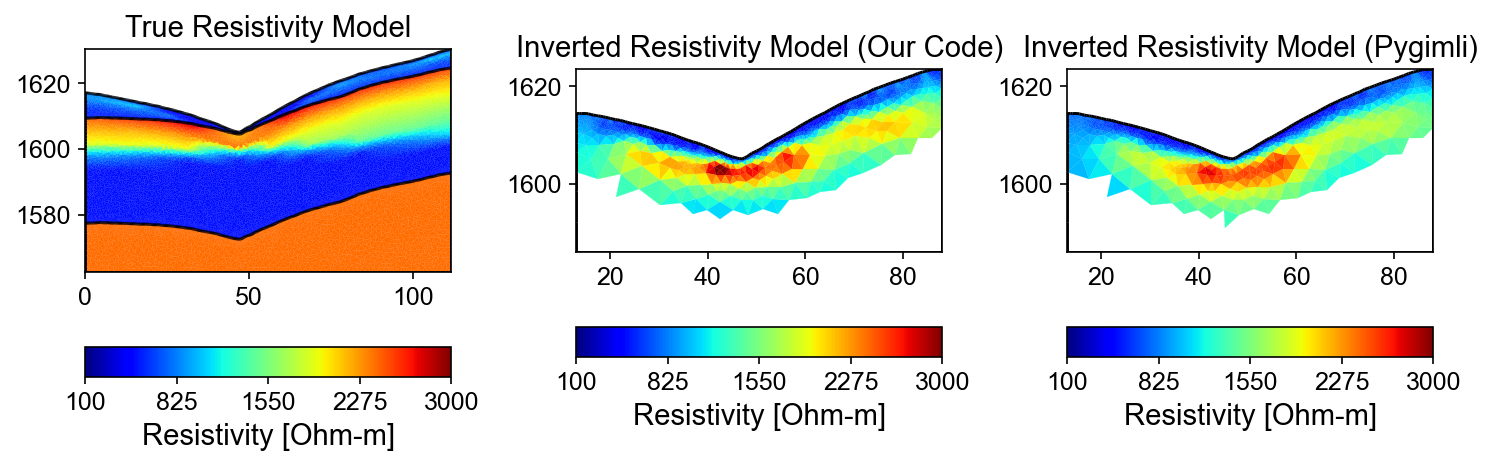

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(10, 12))

# True resistivity model
ax1 = axes[0]
cbar1 = pg.show(mesh, res_models, ax=ax1, cMap='jet', logScale=False, 
              cMin=100, cMax=3000, label='Resistivity [Ohm-m]')
ax1.set_title("True Resistivity Model")

# Inverted model
ax2 = axes[1]
cbar2 = pg.show(inversion_result.mesh, inversion_result.final_model, ax=ax2, cMap='jet', logScale=False, 
              cMin=100, cMax=3000, label='Resistivity [Ohm-m]',coverage=inversion_result.coverage>-1)
ax2.set_title("Inverted Resistivity Model (Our Code)")

ax3 = axes[2]
cbar2 = pg.show(mgr.paraDomain, mgr.paraModel(), ax=ax3, cMap='jet', logScale=False, 
              cMin=100, cMax=3000, label='Resistivity [Ohm-m]',coverage=mgr.coverage()>-1)
ax3.set_title("Inverted Resistivity Model (Pygimli)")
# Adjust layout
plt.tight_layout()



# The inversion results are almost same from this code and Pygimli default inversion.
# the difference is that the chi2 value for stop inversion is not the same, we chose 1.5 while Pygimli is 1.0

# One step approach

## ERT one step from HM to GM

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [3. 3. 3. ... 3. 3. 3.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]]
Resistivity range: 350.63114674639996 - 2863.5857671555473 Ohm-m


22/05/25 - 14:26:33 - pyGIMLi - INFO - Found 2 regions.
22/05/25 - 14:26:33 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
22/05/25 - 14:26:34 - pyGIMLi - INFO - Found 2 regions.
22/05/25 - 14:26:34 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
22/05/25 - 14:26:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
22/05/25 - 14:26:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
22/05/25 - 14:26:35 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 37828 Cells: 74804 Boundaries: 56528


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1fcfe6f55d0>)

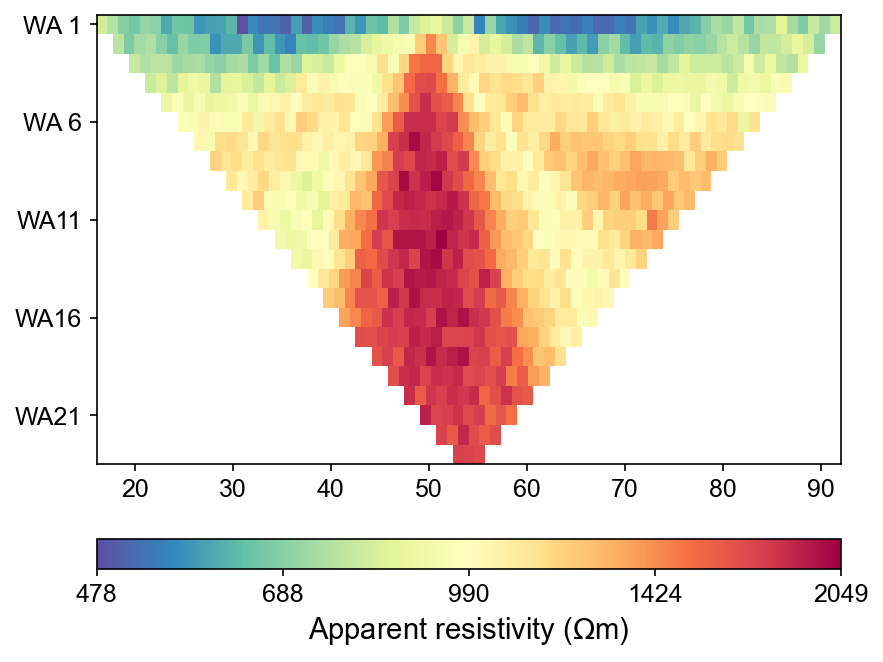

In [26]:
# Set up directories
output_dir = "results/hydro_to_ert_example"
os.makedirs(output_dir, exist_ok=True)

# Load your data
data_dir = "data/"
idomain = np.loadtxt(os.path.join(data_dir, "id.txt"))
top = np.loadtxt(os.path.join(data_dir, "top.txt"))
porosity = np.load(os.path.join(data_dir, "Porosity.npy"))
water_content = np.load(os.path.join(data_dir, "Watercontent.npy"))[50]  # Time step 50

# Set up profile
point1 = [115, 70]  
point2 = [95, 180]  

interpolator = ProfileInterpolator(
    point1=point1,
    point2=point2,
    surface_data=top,
    origin_x=569156.0,
    origin_y=4842444.0,
    pixel_width=1.0,
    pixel_height=-1.0,
    num_points=400
)

# Create mesh structure
bot = np.load(os.path.join(data_dir, "bot.npy"))
layer_idx = [0, 4, 12]  # Example indices for top, middle, and bottom layers
structure = interpolator.interpolate_layer_data([top] + bot.tolist())
surface, line1, line2 = create_surface_lines(
    L_profile=interpolator.L_profile,
    structure=structure,
    top_idx=layer_idx[0],
    mid_idx=layer_idx[1],
    bot_idx=layer_idx[2]
)

# Create mesh
mesh_creator = MeshCreator(quality=32)
mesh, geom = mesh_creator.create_from_layers(
    surface=surface,
    layers=[line1, line2],
    bottom_depth=np.min(line2[:,1])-10
)

# Define layer markers
marker_labels = [0, 3, 2]  # top, middle, bottom layers

# Define resistivity parameters for each layer
rho_parameters = {
    'rho_sat': [100, 500, 2400],      # Saturated resistivity for each layer (Ohm-m)
    'n': [2.2, 1.8, 2.5],             # Cementation exponent for each layer
    'sigma_s': [1/500, 0, 0]          # Surface conductivity for each layer (S/m)
}

mesh_markers = np.array(mesh.cellMarkers())


# Generate ERT response directly
synth_data, res_model = hydro_to_ert(
    water_content=water_content,
    porosity=porosity,
    mesh=mesh,
    mesh_markers = mesh_markers,
    profile_interpolator=interpolator,
    layer_idx=layer_idx,
    structure = structure,
    marker_labels=marker_labels,
    rho_parameters=rho_parameters,
    electrode_spacing=1.0,
    electrode_start=15,
    num_electrodes=72,
    scheme_name='wa',
    noise_level=0.05,
    abs_error=0.0,
    rel_error=0.05,
    save_path=os.path.join(output_dir, "synthetic_ert_data.dat"),
    verbose=True,
    seed=42,
)

ert.showData(synth_data,  logscale=True)

## SRT one step from HM to GM

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg

# Import PyHydroGeophysX modules
from PyHydroGeophysX.core.interpolation import ProfileInterpolator, create_surface_lines
from PyHydroGeophysX.core.mesh_utils import MeshCreator
from PyHydroGeophysX.Hydro_modular.hydro_to_srt import hydro_to_srt

# 1. Set up output directory
output_dir = "results/srt_example"
os.makedirs(output_dir, exist_ok=True)

# Load your data
data_dir = "data/"
idomain = np.loadtxt(os.path.join(data_dir, "id.txt"))
top = np.loadtxt(os.path.join(data_dir, "top.txt"))
porosity = np.load(os.path.join(data_dir, "Porosity.npy"))
water_content = np.load(os.path.join(data_dir, "Watercontent.npy"))[50]  # Time step 50

# Set up profile
point1 = [115, 70]  
point2 = [95, 180]  

interpolator = ProfileInterpolator(
    point1=point1,
    point2=point2,
    surface_data=top,
    origin_x=569156.0,
    origin_y=4842444.0,
    pixel_width=1.0,
    pixel_height=-1.0,
    num_points=400
)

# Create mesh structure
bot = np.load(os.path.join(data_dir, "bot.npy"))
layer_idx = [0, 4, 12]  # Example indices for top, middle, and bottom layers
structure = interpolator.interpolate_layer_data([top] + bot.tolist())
surface, line1, line2 = create_surface_lines(
    L_profile=interpolator.L_profile,
    structure=structure,
    top_idx=layer_idx[0],
    mid_idx=layer_idx[1],
    bot_idx=layer_idx[2]
)

# Create mesh
mesh_creator = MeshCreator(quality=32)
mesh, geom = mesh_creator.create_from_layers(
    surface=surface,
    layers=[line1, line2],
    bottom_depth=np.min(line2[:,1])-10
)

# Define layer markers
marker_labels = [0, 3, 2]  # top, middle, bottom layers

# Rock physics parameters for each layer
vel_parameters = {
    'top': {
        'bulk_modulus': 30.0,         # GPa
        'shear_modulus': 20.0,        # GPa
        'mineral_density': 2650,      # kg/m³
        'depth': 1.0                  # m
    },
    'mid': {
        'bulk_modulus': 50.0,         # GPa
        'shear_modulus': 35.0,        # GPa
        'mineral_density': 2670,      # kg/m³
        'aspect_ratio': 0.05          # Crack aspect ratio
    },
    'bot': {
        'bulk_modulus': 55.0,         # GPa
        'shear_modulus': 50.0,        # GPa
        'mineral_density': 2680,      # kg/m³
        'aspect_ratio': 0.03          # Crack aspect ratio
    }
}
mesh_markers = np.array(mesh.cellMarkers())
# 13. Now we call hydro_to_srt with the pre-processed mesh values
synth_data, velocity_mesh = hydro_to_srt(
    water_content=water_content,           # Use pre-interpolated mesh values
    porosity=porosity,          # Use pre-interpolated mesh values
    mesh=mesh,
    profile_interpolator=interpolator,
    layer_idx=layer_idx,
    structure = structure,
    marker_labels=marker_labels,
    vel_parameters=vel_parameters,
    sensor_spacing=1.0,              
    sensor_start=15.0,               
    num_sensors=72,                  
    shot_distance=5,                 
    noise_level=0.05,                
    noise_abs=0.00001,               
    save_path=os.path.join(output_dir, "synthetic_seismic_data.dat"),
    mesh_markers=mesh_markers,       # Pass the mesh markers directly
    verbose=True,
    seed=1334                        
)

# 14. Visualize the results
from PyHydroGeophysX.forward.srt_forward import SeismicForwardModeling

# Create a figure
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot velocity model
pg.show(mesh, velocity_mesh, ax=axes[0], cMap='jet', 
        cMin=500, cMax=5000, label='Velocity (m/s)',
        xlabel="Distance (m)", ylabel="Elevation (m)")

# Plot first-arrival travel times
SeismicForwardModeling.draw_first_picks(axes[1], synth_data)
axes[1].set_title('Synthetic First-Arrival Travel Times')

plt.tight_layout()
